In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from matplotlib import pyplot as plt

In [2]:
# Categories as specified in the dataset are different to the paper
# This gives the mapping between them
with open("../configs/demetr/cat_correction.yaml") as stream:
    try:
        cat_correction = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [3]:
# Map categories to error severity
# Severity is as specified in the paper
with open("../configs/demetr/cat_severity.yaml") as stream:
    try:
        cat_severity = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

### Load results from DEMETR paper

In [4]:
demetr_results = "../data/demetr_paper_results_tidy.csv"

In [5]:
demetr_df = pd.read_csv(demetr_results)

In [6]:
bleu_baseline = demetr_df[demetr_df.metric == "Bleu"]
comet_baseline = demetr_df[demetr_df.metric == "Comet"]

In [7]:
# Sort and sanity check
# We should have 35 categories
bleu_baseline = bleu_baseline.sort_values("category")
print(len(bleu_baseline))

comet_baseline = comet_baseline.sort_values("category")
print(len(comet_baseline))

35
35


### Load M4ST results

In [8]:
m4st_res_dir = "../outputs/demetr"

In [9]:
res_files = os.listdir(m4st_res_dir)

In [10]:
# Read all files into a single dataframe
results_dataframes = []

for i in range(len(res_files)):
    try:
        res_df = pd.read_json(os.path.join(m4st_res_dir, res_files[i]))
        metric = res_files[i].split("_")[0]
        id = next(c for c in res_files[i].split("_") if "id" in c)
        cat = int(id.strip("id"))
        res_df = res_df.T
        res_df["metric"] = metric
        res_df["sentence_id"] = res_df.index
        res_df["category"] = cat
        results_dataframes.append(res_df)
    except IsADirectoryError:
        pass

all_res = pd.concat(results_dataframes)

In [12]:
all_res.head(1)

,source_language,mt_score,disfluent_score,metric,sentence_id,category
1,chinese_simple,73.613919,19.173356,ChrF1,1,34


In [13]:
# Correct categories to align with the paper
all_res["category"] = all_res["category"].replace(cat_correction)

In [14]:
# Add column indicating DEMETR accuracy
all_res["correct"] = all_res["mt_score"] > all_res["disfluent_score"]

In [15]:
# Accuracy is reversed for category 35 (reference as translation) so need to adjust that
cat_to_rev = all_res.loc[all_res["category"] == 35]
cat_to_rev

,source_language,mt_score,disfluent_score,metric,sentence_id,category,correct
1,chinese_simple,0.999132,1.0,XCOMET-XXL,1,35,False
2,chinese_simple,1.0,0.999354,XCOMET-XXL,2,35,True
3,chinese_simple,1.0,0.997073,XCOMET-XXL,3,35,True
4,chinese_simple,0.995413,1.0,XCOMET-XXL,4,35,False
5,chinese_simple,0.988401,0.930063,XCOMET-XXL,5,35,True
...,...,...,...,...,...,...,...
996,italian,74.188438,100.0,ChrF2,996,35,False
997,italian,69.348646,100.0,ChrF2,997,35,False
998,italian,51.522835,100.0,ChrF2,998,35,False
999,italian,93.826029,100.0,ChrF2,999,35,False


In [16]:
cat_to_rev["correct"] = cat_to_rev["mt_score"] < cat_to_rev["disfluent_score"]
cat_to_rev

/var/folders/z4/mf_7gqbs75d6y4sj_xb9t80w0000gr/T/ipykernel_99881/1405697321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_to_rev["correct"] = cat_to_rev["mt_score"] < cat_to_rev["disfluent_score"]


,source_language,mt_score,disfluent_score,metric,sentence_id,category,correct
1,chinese_simple,0.999132,1.0,XCOMET-XXL,1,35,True
2,chinese_simple,1.0,0.999354,XCOMET-XXL,2,35,False
3,chinese_simple,1.0,0.997073,XCOMET-XXL,3,35,False
4,chinese_simple,0.995413,1.0,XCOMET-XXL,4,35,True
5,chinese_simple,0.988401,0.930063,XCOMET-XXL,5,35,False
...,...,...,...,...,...,...,...
996,italian,74.188438,100.0,ChrF2,996,35,True
997,italian,69.348646,100.0,ChrF2,997,35,True
998,italian,51.522835,100.0,ChrF2,998,35,True
999,italian,93.826029,100.0,ChrF2,999,35,True


In [17]:
# Reassign values to original dataframe
all_res.loc[all_res["category"] == 35, "correct"] = cat_to_rev.correct

In [18]:
# Check result
all_res.loc[all_res["category"] == 35]

,source_language,mt_score,disfluent_score,metric,sentence_id,category,correct
1,chinese_simple,0.999132,1.0,XCOMET-XXL,1,35,True
2,chinese_simple,1.0,0.999354,XCOMET-XXL,2,35,False
3,chinese_simple,1.0,0.997073,XCOMET-XXL,3,35,False
4,chinese_simple,0.995413,1.0,XCOMET-XXL,4,35,True
5,chinese_simple,0.988401,0.930063,XCOMET-XXL,5,35,False
...,...,...,...,...,...,...,...
996,italian,74.188438,100.0,ChrF2,996,35,True
997,italian,69.348646,100.0,ChrF2,997,35,True
998,italian,51.522835,100.0,ChrF2,998,35,True
999,italian,93.826029,100.0,ChrF2,999,35,True


In [19]:
# Add column for severity
all_res["severity"] = all_res["category"].map(cat_severity)

In [20]:
all_res.head(5)

,source_language,mt_score,disfluent_score,metric,sentence_id,category,correct,severity
1,chinese_simple,73.613919,19.173356,ChrF1,1,33,True,base
2,chinese_simple,82.892551,17.013595,ChrF1,2,33,True,base
3,chinese_simple,71.757296,18.575202,ChrF1,3,33,True,base
4,chinese_simple,72.900449,13.572237,ChrF1,4,33,True,base
5,chinese_simple,53.857323,18.03467,ChrF1,5,33,True,base


In [21]:
all_res.to_csv("../outputs/demetr/all/all.csv", index=False)

Text(0.5, 1.0, 'Mean performance across all 35 categories')

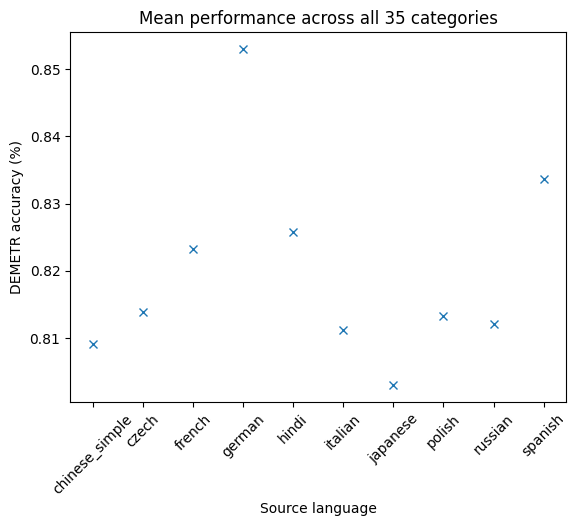

In [22]:
# TODO: error bars

fig, axs = plt.subplots()
by_language = all_res.groupby("source_language")["correct"].mean()
axs.plot(by_language, "x")
plt.xticks(np.arange(10), by_language.index, rotation=45)
plt.ylabel("DEMETR accuracy (%)")
plt.xlabel("Source language")
plt.title("Mean performance across all 35 categories")

Text(0.5, 1.0, 'Mean performance for each error type')

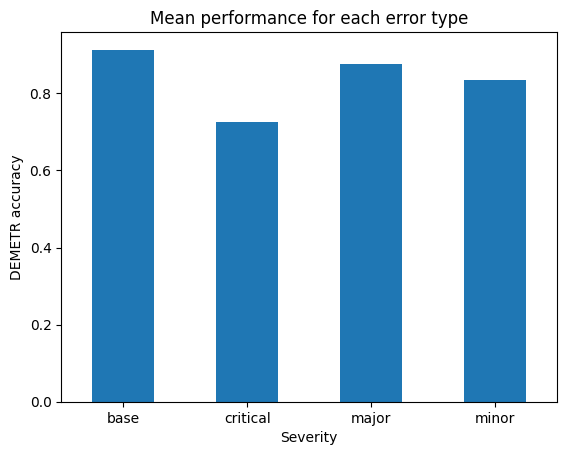

In [23]:
fig, axs = plt.subplots()
by_severity = all_res.groupby("severity")["correct"].mean()
by_severity.plot(kind="bar")
plt.xticks(np.arange(4), by_severity.index, rotation=0)
plt.ylabel("DEMETR accuracy")
plt.xlabel("Severity")
plt.title("Mean performance for each error type")

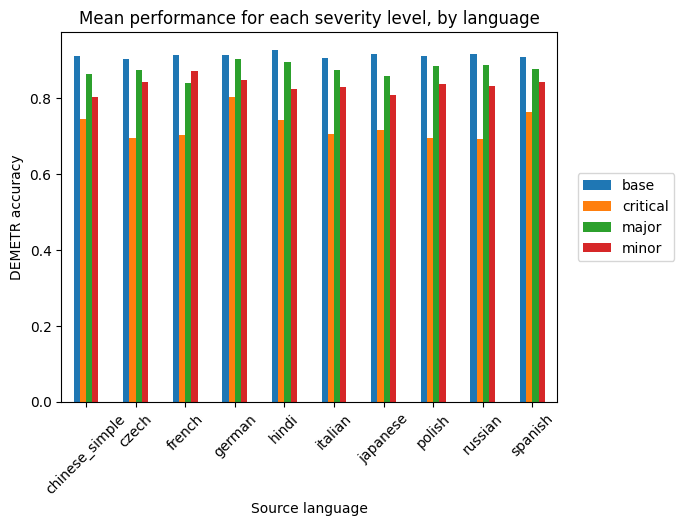

In [24]:
# Probably skip in report
fig, axs = plt.subplots()
sev_by_lang = all_res.groupby(["source_language", "severity"])["correct"].mean()
sev_by_lang.unstack().plot(kind="bar", ax=axs)
plt.xticks(rotation=45)
plt.ylabel("DEMETR accuracy")
plt.xlabel("Source language")
plt.title("Mean performance for each severity level, by language")
plt.legend(loc="right", bbox_to_anchor=(1.25, 0.5))

In [25]:
# Tidy up COMET naming
all_res["metric"] = all_res.metric.replace(
    {
        "wmt22-comet-da": "wmt22-COMET",
        "wmt22-cometkiwi-da": "wmt22-COMETKiwi",
        "Bleu": "BLEU",
    }
)

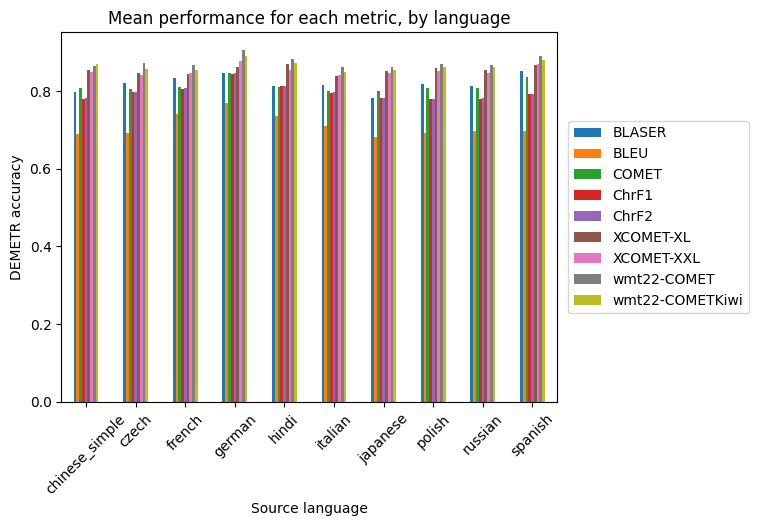

In [26]:
# TODO: Extract this as a table

fig, axs = plt.subplots()
sev_by_lang = all_res.groupby(["source_language", "metric"])["correct"].mean()
sev_by_lang.unstack().plot(kind="bar", ax=axs)
plt.xticks(rotation=45)
plt.ylabel("DEMETR accuracy")
plt.xlabel("Source language")
plt.title("Mean performance for each metric, by language")
plt.legend(loc="right", bbox_to_anchor=(1.4, 0.5))

In [ ]:
to_table = sev_by_lang.reset_index()

AttributeError: 'Series' object has no attribute 'source_language'

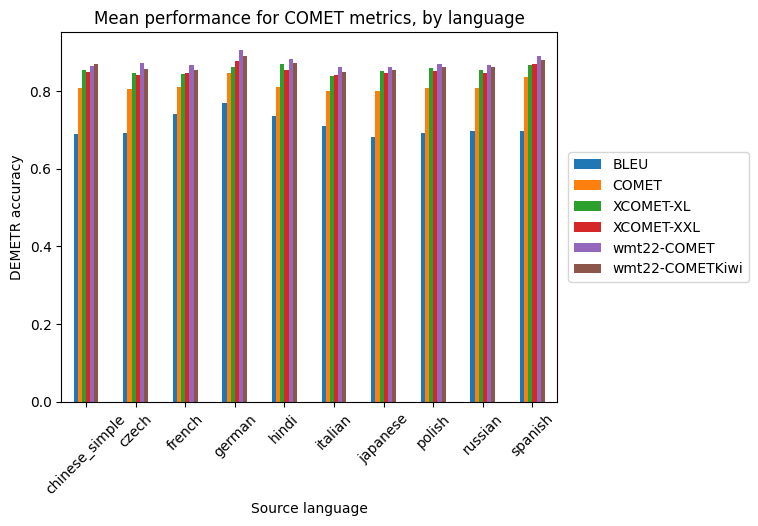

In [73]:
fig, axs = plt.subplots()
sev_by_lang = all_res.groupby(["source_language", "metric"])["correct"].mean()
sev_by_lang.unstack().drop(columns=["BLASER", "ChrF2", "ChrF1"]).plot(
    kind="bar", ax=axs
)
plt.xticks(rotation=45)
plt.ylabel("DEMETR accuracy")
plt.xlabel("Source language")
plt.title("Mean performance for COMET metrics, by language")
plt.legend(loc="right", bbox_to_anchor=(1.4, 0.5))

Text(0.5, 1.0, 'Mean performance across all languages')

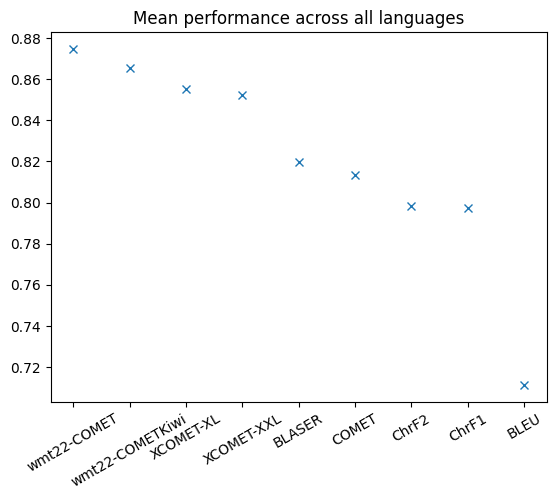

In [ ]:
fig, axs = plt.subplots()
sorted_overall_mean = (
    all_res.groupby(["metric"])["correct"].mean().sort_values(ascending=False)
)
axs.plot(sorted_overall_mean, "x")
plt.xticks(rotation=30)
plt.xlabel("Metric")
plt.ylabel("Accuracy")
# plt.title("Mean performance across all languages")

In [48]:
all_res

,source_language,mt_score,disfluent_score,metric,sentence_id,category,correct,severity
1,chinese_simple,73.613919,19.173356,ChrF1,1,33,True,base
2,chinese_simple,82.892551,17.013595,ChrF1,2,33,True,base
3,chinese_simple,71.757296,18.575202,ChrF1,3,33,True,base
4,chinese_simple,72.900449,13.572237,ChrF1,4,33,True,base
5,chinese_simple,53.857323,18.03467,ChrF1,5,33,True,base
...,...,...,...,...,...,...,...,...
996,italian,0.989141,0.946483,XCOMET-XL,996,6,True,critical
997,italian,0.990359,0.945723,XCOMET-XL,997,6,True,critical
998,italian,0.988565,0.94941,XCOMET-XL,998,6,True,critical
999,italian,0.999375,0.985015,XCOMET-XL,999,6,True,critical


In [43]:
all_res

,source_language,mt_score,disfluent_score,metric,sentence_id,category,correct,severity
1,chinese_simple,73.613919,19.173356,ChrF1,1,33,True,base
2,chinese_simple,82.892551,17.013595,ChrF1,2,33,True,base
3,chinese_simple,71.757296,18.575202,ChrF1,3,33,True,base
4,chinese_simple,72.900449,13.572237,ChrF1,4,33,True,base
5,chinese_simple,53.857323,18.03467,ChrF1,5,33,True,base
...,...,...,...,...,...,...,...,...
996,italian,0.989141,0.946483,XCOMET-XL,996,6,True,critical
997,italian,0.990359,0.945723,XCOMET-XL,997,6,True,critical
998,italian,0.988565,0.94941,XCOMET-XL,998,6,True,critical
999,italian,0.999375,0.985015,XCOMET-XL,999,6,True,critical


In [63]:
corr_by_category = (
    all_res.groupby(["metric", "category"])["correct"].mean().reset_index()
)
corr_by_category

,metric,category,correct
0,BLASER,1,0.9640
1,BLASER,2,0.9945
2,BLASER,3,0.8185
3,BLASER,4,0.9195
4,BLASER,5,0.8405
...,...,...,...
307,wmt22-COMETKiwi,31,0.9720
308,wmt22-COMETKiwi,32,1.0000
309,wmt22-COMETKiwi,33,1.0000
310,wmt22-COMETKiwi,34,1.0000


In [73]:
grouped = corr_by_category.groupby("metric").median().sort_values(by="correct")

/var/folders/z4/mf_7gqbs75d6y4sj_xb9t80w0000gr/T/ipykernel_99881/356547050.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(rotation=30, labels=axs.get_xticklabels())


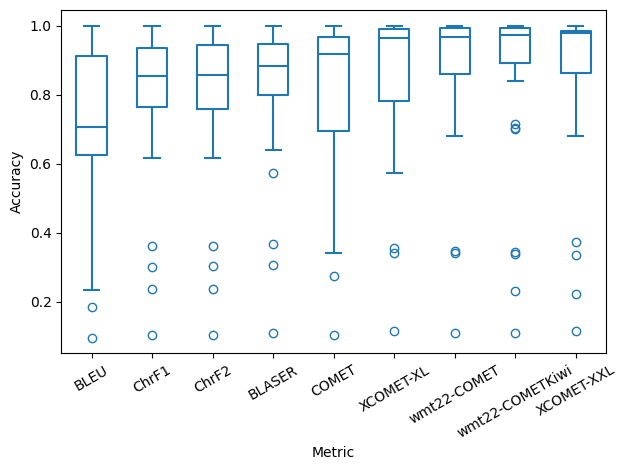

In [76]:
fig, axs = plt.subplots()
g = sns.boxplot(
    corr_by_category,
    x="metric",
    y="correct",
    fill=False,
    ax=axs,
    width=0.5,
    order=grouped.index,
)
axs.set_xticklabels(rotation=30, labels=axs.get_xticklabels())
axs.set_xlabel("Metric")
axs.set_ylabel("Accuracy")
plt.tight_layout()
plt.savefig("../outputs/demetr/plots/metrics-boxplot.png")

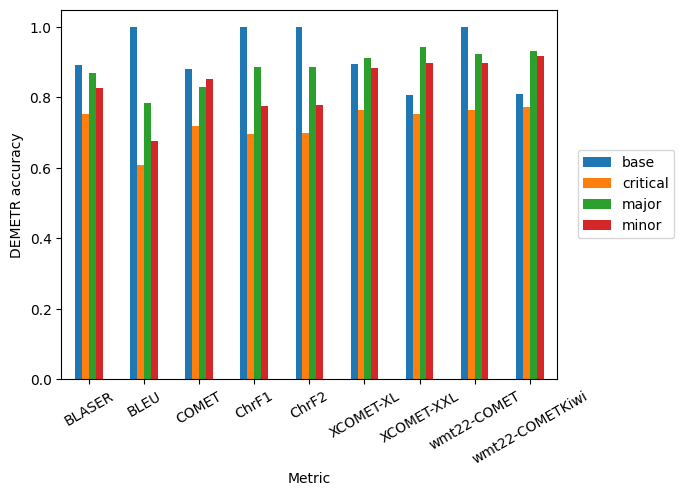

In [50]:
# What trend would be desirable here? Include in report

fig, axs = plt.subplots()
sev_by_lang = all_res.groupby(["metric", "severity"])["correct"].mean()
sev_by_lang.unstack().plot(kind="bar", ax=axs)
plt.xticks(rotation=30)
plt.ylabel("DEMETR accuracy")
plt.xlabel("Metric")
# plt.title("Mean performance for each severity level by metric")
plt.legend(loc="right", bbox_to_anchor=(1.25, 0.5))

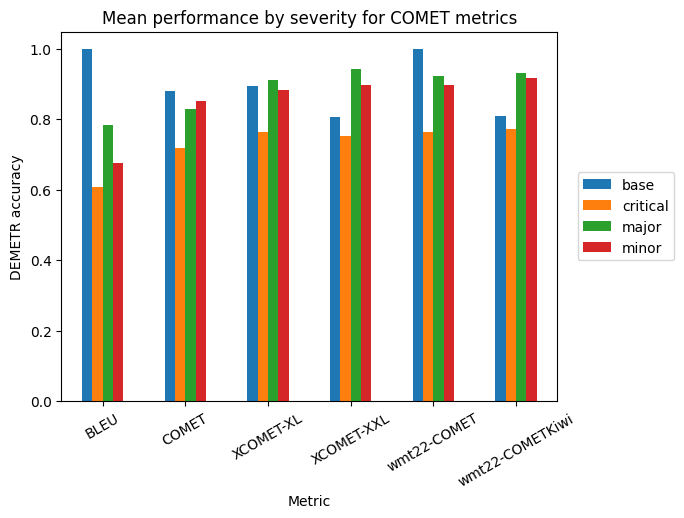

In [82]:
fig, axs = plt.subplots()
sev_by_lang = all_res.groupby(["metric", "severity"])["correct"].mean()
sev_by_lang.unstack().drop(["BLASER", "ChrF2", "ChrF1"]).plot(kind="bar", ax=axs)
plt.xticks(rotation=30)
plt.ylabel("DEMETR accuracy")
plt.xlabel("Metric")
plt.title("Mean performance by severity for COMET metrics")
plt.legend(loc="right", bbox_to_anchor=(1.25, 0.5))

### Comparison between M4ST and original paper

In [40]:
m4st_blaser = (
    all_res[all_res.metric == "BLASER"].groupby("category").correct.mean() * 100
)
m4st_comet = all_res[all_res.metric == "COMET"].groupby("category").correct.mean() * 100
m4st_bleu = all_res[all_res.metric == "Bleu"].groupby("category").correct.mean() * 100

In [41]:
diff_paper = np.array(m4st_blaser) - np.array(comet_baseline.accuracy)
diff_new = np.array(m4st_blaser) - np.array(m4st_comet)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(list(range(1, 36)), diff_paper, "ko")
axs[0].axhline(0, linestyle="--", c="r")
axs[0].set_title("BLASER-2 vs. COMET (Baseline)")
axs[0].set_ylabel("Difference (BLASER-2 - COMET)")
axs[0].set_xlabel("DEMETR category")

# TODO: This plot separated so we BLASER-2 vs the best COMET metric
axs[1].plot(list(range(1, 36)), diff_new, "ko")
axs[1].axhline(0, linestyle="--", c="r")
axs[1].set_title("BLASER-2 vs. COMET (M4ST)")
axs[1].set_ylabel("Difference (BLASER-2 - COMET)")
axs[1].set_xlabel("DEMETR category")

In [43]:
diff_paper = np.array(m4st_blaser) - np.array(bleu_baseline.accuracy)
diff_new = np.array(m4st_blaser) - np.array(m4st_bleu)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(list(range(1, 36)), diff_paper, "ko")
axs[0].axhline(0, linestyle="--", c="r")
axs[0].set_title("BLASER-2 vs. Bleu (Baseline)")
axs[0].set_ylabel("Difference (BLASER-2 - Bleu)")
axs[0].set_xlabel("DEMETR category")

axs[1].plot(list(range(1, 36)), diff_new, "ko")
axs[1].axhline(0, linestyle="--", c="r")
axs[1].set_title("BLASER-2 vs. Bleu (M4ST)")
axs[1].set_ylabel("Difference (BLASER-2 - Bleu)")
axs[1].set_xlabel("DEMETR category")

### Compare BLASER to Bleu/COMET

In [ ]:
demetr_df.head(1)

In [70]:
demetr_df["metric"] = demetr_df.metric.replace({"Comet": "COMET", "ChrF": "ChrF1"})

In [ ]:
np.unique(all_res.metric)

In [ ]:
np.unique(demetr_df.metric)

In [73]:
# Subset DEMETR paper results to match the metrics I used
demetr_df_match = demetr_df[demetr_df.metric.isin(np.unique(all_res.metric))]

In [ ]:
demetr_df_match

In [75]:
m4st_by_cat = all_res[["metric", "category", "correct"]].groupby(["category", "metric"])
m4st_by_cat = m4st_by_cat.correct.mean().reset_index()

In [ ]:
m4st_by_cat

In [77]:
# Adjust percentage
m4st_by_cat["correct"] = m4st_by_cat["correct"] * 100

In [ ]:
# Add column for plotting by source
demetr_df_match["source"] = "Karpinska et al."

In [79]:
m4st_by_cat["source"] = "ARC"
m4st_by_cat = m4st_by_cat.rename(columns={"correct": "accuracy"})

In [80]:
merged = pd.merge(
    demetr_df_match,
    m4st_by_cat,
    on=["category", "metric", "source", "accuracy"],
    how="outer",
)

In [ ]:
merged

In [82]:
merged = merged[merged.metric.isin(["Bleu", "COMET", "ChrF1", "ChrF2"])]

In [ ]:
g = sns.catplot(
    data=merged[merged.category <= 15],
    kind="bar",
    x="category",
    y="accuracy",
    hue="source",
    errorbar="sd",
    palette="dark",
    alpha=0.6,
    height=6,
    aspect=11.7 / 8.27,
)
g.despine(left=True)
g.set_axis_labels("Category", "Accuracy")
g.legend.set_title("")

In [ ]:
g = sns.catplot(
    data=merged[merged.category > 15],
    kind="bar",
    x="category",
    y="accuracy",
    hue="source",
    errorbar="sd",
    palette="dark",
    alpha=0.6,
    height=6,
    aspect=11.7 / 8.27,
)
g.despine(left=True)
g.set_axis_labels("Category", "Accuracy")
g.legend.set_title("")

### BLASER only

In [356]:
m4st_res_dir = "../outputs/demetr"

In [357]:
blaser_new_15 = pd.read_json(
    os.path.join(m4st_res_dir, "BLASER_REF_minor_id15_case.json")
)
blaser_new_8 = pd.read_json(
    os.path.join(m4st_res_dir, "BLASER_Ref_critical_id8_negation.json")
)
blaser_new_6 = pd.read_json(
    os.path.join(m4st_res_dir, "BLASER_Ref_critical_id6_addition.json")
)

In [ ]:
blaser_new_15

In [361]:
blaser_new_15 = blaser_new_15.T
blaser_new_8 = blaser_new_8.T
blaser_new_6 = blaser_new_6.T

In [ ]:
blaser_new_8

In [ ]:
np.unique(blaser_new_15.source_language)

In [364]:
blaser_new_15["diff"] = blaser_new_15.mt_score - blaser_new_15.disfluent_score
blaser_new_8["diff"] = blaser_new_8.mt_score - blaser_new_8.disfluent_score
blaser_new_6["diff"] = blaser_new_6.mt_score - blaser_new_6.disfluent_score

In [ ]:
blaser_new_15

In [ ]:
fig, axs = plt.subplots()
blaser_new_15.groupby("source_language").mean()["diff"].plot(ax=axs)
blaser_new_8.groupby("source_language").mean()["diff"].plot(ax=axs)
blaser_new_6.groupby("source_language").mean()["diff"].plot(ax=axs)

fig.legend(
    labels=["Pronoun case", "Negation", "Addition"],
    loc="right",
    bbox_to_anchor=(1.15, 0.5),
)
axs.set_ylabel("Score difference")
plt.xticks(np.arange(10), np.unique(blaser_new_15.source_language), rotation=30)